In [37]:
import os
import numpy as np
import pandas as pd
from random import shuffle
import matplotlib.image as mpimg
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [2]:
PATH_FOR_POS = '/Users/aleksejfilippov/Desktop/Python_projects/NN_for_Tanurkov/wavelet_img/quake'
PATH_FOR_NEG = '/Users/aleksejfilippov/Desktop/Python_projects/NN_for_Tanurkov/wavelet_img/non-quake'
PATH_FOR_BOTH = '/Users/aleksejfilippov/Desktop/Python_projects/NN_for_Tanurkov/wavelet_img/both'
PATH_FOR_CSV_MAP = '/Users/aleksejfilippov/Desktop/Python_projects/NN_for_Tanurkov/wavelet_img/image_map.csv'

In [3]:
# number_of_positives = len(os.listdir(PATH_FOR_POS))
# number_of_negatives = len(os.listdir(PATH_FOR_NEG))

# names_list = os.listdir(PATH_FOR_POS) + os.listdir(PATH_FOR_NEG)
# labels = [1] * number_of_positives + [0] * number_of_negatives
# samples = [(im, label) for im, label in zip(names_list, labels)]
# shuffle(samples)

# delimiter = '±'
# with open(PATH_FOR_CSV_MAP, 'a') as the_file:
#         the_file.write('path±label\n')
# for fname, label in samples:
#     with open(PATH_FOR_CSV_MAP, 'a') as the_file:
#         the_file.write(fname+delimiter+str(label)+'\n')

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
PATH_FOR_POS = '/Users/aleksejfilippov/Desktop/Python_projects/NN_for_Tanurkov/wavelet_img/quake'
PATH_FOR_NEG = '/Users/aleksejfilippov/Desktop/Python_projects/NN_for_Tanurkov/wavelet_img/non-quake'

number_of_positives = len(os.listdir(PATH_FOR_POS))
number_of_negatives = len(os.listdir(PATH_FOR_NEG))
total_number = number_of_negatives + number_of_positives

train_percent = 0.85
validation_percent = 0.15  #out of train 

train_capacity = 8040
test_capacity = 1400

print('Total number of samles: ', number_of_negatives + number_of_positives)
print('Number of positive samles: ', number_of_positives)
print('Number of negative samles: ', number_of_negatives)
print('Train : {} samples'.format(train_capacity))
print('Test : {} samples'.format(test_capacity))

Total number of samles:  9484
Number of positive samles:  2940
Number of negative samles:  6544
Train : 8040 samples
Test : 1400 samples


In [5]:
class EarthQuakeDataset(Dataset):

    def __init__(self, train:bool, both_path, map_path, transform=None):
        """
        Args:
            pos_dir (string): Directory with all the images with earthquakes.
            neg_dir (string): Directory with all the images without earthquakes.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.map_ = pd.read_csv(map_path, sep = '±')
        self.map_.path = self.map_.path.apply(lambda x: both_path+'/'+x)
        
        if train:
            self.img_paths = self.map_.path[:train_capacity]
            self.labels = self.map_.label[:train_capacity]
        elif train != True:
            self.img_paths = self.map_.path[train_capacity:train_capacity+test_capacity].tolist()
            self.labels = self.map_.label[train_capacity:train_capacity+test_capacity].tolist()
        else:
            raise Exception('Parameter train must be set bull')
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        image = mpimg.imread(self.img_paths[idx])[:-1, :-1]
        label = self.labels[idx]

        return image, label

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
train_set = EarthQuakeDataset(train = True, both_path = PATH_FOR_BOTH, map_path = PATH_FOR_CSV_MAP, transform = transform)
test_set = EarthQuakeDataset(train = False, both_path = PATH_FOR_BOTH, map_path = PATH_FOR_CSV_MAP, transform = transform)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':


In [7]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2)
    return(train_loader)

In [8]:
#Test and validation loaders have constant batch sizes, so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, num_workers=2)

In [26]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.functional.binary_cross_entropy
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [27]:
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (1, 82, 82)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 41 * 41, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (1, 82, 82) to (18, 82, 82)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 82, 82) to (18, 41, 41)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 41, 41) to (1, 30258)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 41 *41)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 30258) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 20)
        x = self.fc2(x)
        
        x = self.sigmoid(x)
        return(x)

In [28]:
net = SimpleCNN()
train_loader = get_train_loader(20)
n_batches = len(train_loader)
learning_rate = 0.001
#Create our loss and optimizer functions
loss, optimizer = createLossAndOptimizer(net, learning_rate)

In [ ]:
# dd = []
# for i, data in enumerate(train_loader):
#     if i<3:
#         dd.append(data)
#     else:break

# inputs, labels = dd[0]
# inputs = inputs.view((inputs.shape[0],1, inputs.shape[2], inputs.shape[2]))

# #Wrap them in a Variable object
# inputs, labels = Variable(inputs), Variable(labels)

# #Set the parameter gradients to zero
# optimizer.zero_grad()

# #Forward pass, backward pass, optimize
# outputs = net(inputs)
# # loss_size = loss(outputs, labels)
# labels, outputs

In [42]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    test_losses = []
    train_losses = []
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader):
            
            #Get inputs
            inputs, labels = data
            inputs = inputs.view((inputs.shape[0],1, inputs.shape[2], inputs.shape[2]))
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels.type(torch.FloatTensor))
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        train_losses.append(total_train_loss/len(train_loader))
        #At the end of the epoch, do a pass on the validation set
        total_test_loss = 0
        for inputs, labels in test_loader:
            
            #Wrap tensors in Variables
            inputs = inputs.view((inputs.shape[0],1, inputs.shape[2], inputs.shape[2]))
            inputs, labels = Variable(inputs), Variable(labels.type(torch.FloatTensor))
            
            #Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
            
        print("Test loss = {:.2f}".format(total_test_loss / len(test_loader)))
        test_losses.append(total_test_loss / len(test_loader))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    return train_losses, test_losses

In [43]:
CNN = SimpleCNN()
tr, te = trainNet(CNN, batch_size=20, n_epochs=2, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 20
epochs= 2
learning_rate= 0.001


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 1, 10% 	 train_loss: 0.64 took: 4.64s
Epoch 1, 20% 	 train_loss: 0.60 took: 4.08s
Epoch 1, 30% 	 train_loss: 0.46 took: 4.02s
Epoch 1, 40% 	 train_loss: 0.43 took: 3.97s
Epoch 1, 50% 	 train_loss: 0.39 took: 3.98s
Epoch 1, 61% 	 train_loss: 0.42 took: 3.92s
Epoch 1, 71% 	 train_loss: 0.39 took: 4.07s
Epoch 1, 81% 	 train_loss: 0.41 took: 3.99s
Epoch 1, 91% 	 train_loss: 0.40 took: 4.00s
Test loss = 0.35
Epoch 2, 10% 	 train_loss: 0.37 took: 4.07s
Epoch 2, 20% 	 train_loss: 0.38 took: 3.87s
Epoch 2, 30% 	 train_loss: 0.36 took: 4.00s
Epoch 2, 40% 	 train_loss: 0.32 took: 3.79s
Epoch 2, 50% 	 train_loss: 0.31 took: 4.39s
Epoch 2, 61% 	 train_loss: 0.37 took: 4.99s
Epoch 2, 71% 	 train_loss: 0.32 took: 5.20s
Epoch 2, 81% 	 train_loss: 0.36 took: 7.85s
Epoch 2, 91% 	 train_loss: 0.34 took: 8.77s
Test loss = 0.32
Training finished, took 98.12s


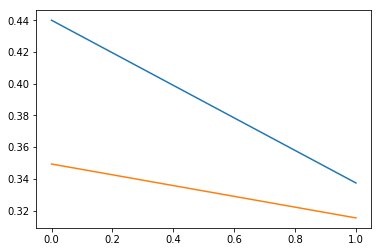

In [44]:
plt.plot(range(len(tr)), tr)
plt.plot(range(len(te)), te)
plt.show()

In [43]:
map_for_testing = pd.read_csv(PATH_FOR_CSV_MAP, sep = '±')
map_for_testing.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,path,label
0,trace-628-p0-2016-11-25_05-00-00_338620-y.png,1
1,mat_trace-624-2016-11-27_13-00-00_sample_34423...,0
2,mat_trace-624-2016-11-24_04-00-00_sample_11526...,0
3,mat_trace-624-2016-11-07_09-00-00_sample_12652...,0
4,mat_trace-620-2016-11-11_12-00-00_sample_11355...,0


Image of an earthquake


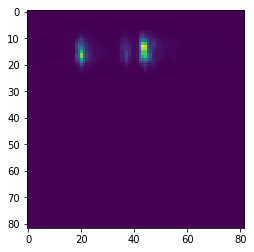

In [65]:
rand_idx = np.random.randint(len(map_for_testing))
path_for_random_img = PATH_FOR_BOTH+'/'+map_for_testing.path[rand_idx]
label_for_random_img = map_for_testing.label[rand_idx]

# Need to crop an image from shape (83, 83) to (82, 82) because of convolutional layers
image = mpimg.imread(path_for_random_img)[:-1, :-1]
if label_for_random_img == 0:
    print("=" * 30)
    print('Image of non-earthquake')
    print("=" * 30)
elif label_for_random_img == 1:
    print("=" * 30)
    print('Image of an earthquake')
    print("=" * 30)
plt.imshow(image)

image = torch.tensor(image)
image = image.view((1,1, image.shape[1], image.shape[1]))
res = CNN(image)


In [71]:
res.tolist()[0][]

[-0.7195559144020081, 0.9980766177177429]